In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lane-detection-for-carla-driving-simulator/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_928_validation_set_label.png
/kaggle/input/lane-detection-for-carla-driving-simulator/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_98_validation_set_label.png
/kaggle/input/lane-detection-for-carla-driving-simulator/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_107_validation_set_label.png
/kaggle/input/lane-detection-for-carla-driving-simulator/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_623_validation_set_label.png
/kaggle/input/lane-detection-for-carla-driving-simulator/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_94_validation_set_label.png
/kaggle/input/lane-detection-for-carla-driving-simulator/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_948_validation_set_label.png
/kaggle/input/lane-detection-for-carla-driving-simulator/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_631_validation_set_label.png
/kaggle/input/lane-det

In [ ]:
'''del model
del optimizer
del scheduler
del criterion
torch.cuda.empty_cache()'''


In [2]:
# STEP 1: Install Required Libraries
!pip install segmentation-models-pytorch
!pip install albumentations

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 3.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=655f70fcaa924bfbb2ac7ad30fdf8bc1944186a038aebe1a8aac0c4a1822b2df
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=bdb5a90faec4e50a20d2e0cf6825f8a44a6cb9f4b97113ecf56f757efdfb18e4
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from sklearn.model_selection import train_test_split



/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
print(torch.cuda.memory_allocated() / 1024**3, "GB allocated")  # Should be 0 GB
print(torch.cuda.memory_reserved() / 1024**3, "GB reserved")   # Should be 0 GB or minimal

In [ ]:
import gc

# Clear GPU memory
torch.cuda.empty_cache()  # Clears the memory cache
gc.collect()  # Run garbage collection to free up unused memory

In [4]:
# Directory paths for the dataset
train_image_dir = '/kaggle/input/lane-detection-for-carla-driving-simulator/train'
train_mask_dir = '/kaggle/input/lane-detection-for-carla-driving-simulator/train_label'
val_image_dir = '/kaggle/input/lane-detection-for-carla-driving-simulator/val'
val_mask_dir = '/kaggle/input/lane-detection-for-carla-driving-simulator/val_label'

In [5]:
num_classes = 3

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=10, p=0.5),
    A.GaussianBlur(p=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

**Making Segmentation Dataset**

In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name.replace('.png', '_label.png')
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        image = np.array(image)
        mask = np.array(mask)
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Ensure mask is a long tensor
        mask = mask.long() if isinstance(mask, torch.Tensor) else torch.from_numpy(mask).long()
        
        return image, mask

In [7]:
# Split training set into train and test
full_train_list = os.listdir(train_image_dir)

train_list, test_list = train_test_split(full_train_list, test_size=0.01, random_state=42)

val_list = os.listdir(val_image_dir)


In [10]:
train_dataset = SegmentationDataset(
    image_dir=train_image_dir,
    mask_dir=train_mask_dir,
    transform=train_transform
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

val_dataset = SegmentationDataset(
    image_dir=val_image_dir,
    mask_dir=val_mask_dir,
    transform=val_transform
)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

Switching to gpu

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**U-Net Archtecture**

In [11]:
model = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
    activation=None,
    decoder_attention_type="scse"
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 235MB/s]


***MIoU and Dice Coefficients***

In [12]:
ce_loss = nn.CrossEntropyLoss()
dice_loss = smp.losses.DiceLoss(mode='multiclass', classes=3, from_logits=True)

def combined_loss(output, target):
    return 0.5 * ce_loss(output, target) + 0.5 * dice_loss(output, target)

In [13]:
def calculate_iou(pred, target, num_classes):
    pred = torch.argmax(pred, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()
        if union == 0:
            iou = 1.0
        else:
            iou = intersection / union
        ious.append(iou)
    return sum(ious) / len(ious)

In [14]:
model = model.to('cuda')

# Create random input tensor
x = torch.randn(4, 3, 256, 256).to('cuda')

# Forward pass
out = model(x)  # DeepLabV3+ returns a dict, extract 'out'

# Print output shape
print(out.shape)  # Expected: torch.Size([4, 3, 256, 256])

torch.Size([4, 3, 256, 256])


***Training and Validation loop***

In [15]:
def train_model(model, train_loader, val_loader, num_epochs=50, patience=10):
    best_val_miou = 0.0
    epochs_no_improve = 0
    best_model_path = '/kaggle/working/best_model.pth'
    latest_model_path = '/kaggle/working/latest_model.pth'
    
    train_losses = []
    val_losses = []
    train_mious = []
    val_mious = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        train_samples = 0
        
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(images)
                loss = combined_loss(outputs, masks)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item() * images.size(0)
            train_iou += calculate_iou(outputs, masks, num_classes=3) * images.size(0)
            train_samples += images.size(0)
        
        train_loss /= train_samples
        train_miou = train_iou / train_samples
        
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        val_samples = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                with autocast():
                    outputs = model(images)
                    loss = combined_loss(outputs, masks)
                
                val_loss += loss.item() * images.size(0)
                val_iou += calculate_iou(outputs, masks, num_classes=3) * images.size(0)
                val_samples += images.size(0)
        
        val_loss /= val_samples
        val_miou = val_iou / val_samples
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_mious.append(train_miou)
        val_mious.append(val_miou)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train MIoU: {train_miou:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val MIoU: {val_miou:.4f}')
        
        # Save model for this epoch, overwriting previous epoch's model
        torch.save(model.state_dict(), latest_model_path)
        print(f'Saved latest model for epoch {epoch+1} at {latest_model_path}')
        
        # Save best model if MIoU improves
        if val_miou > best_val_miou:
            best_val_miou = val_miou
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            print(f'Saved best model with Val MIoU: {val_miou:.4f} at {best_model_path}')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after epoch {epoch+1}')
                break
        
        scheduler.step(val_loss)
    
    return train_losses, val_losses, train_mious, val_mious

In [16]:
from torch.amp import GradScaler

ce_loss = nn.CrossEntropyLoss()
dice_loss = smp.losses.DiceLoss(mode='multiclass', classes=3, from_logits=True)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)  # removed verbose=True
scaler = GradScaler()


**Training**

In [17]:
train_losses, val_losses, train_mious, val_mious = train_model(
    model, train_loader, val_loader, num_epochs=50, patience=10
)

Epoch 1/50:   0%|          | 0/193 [00:00<?, ?it/s]<ipython-input-15-fe0581944a11>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50: 100%|██████████| 193/193 [01:30<00:00,  2.14it/s]
<ipython-input-15-fe0581944a11>:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50
Train Loss: 0.4650, Train MIoU: 0.4367
Val Loss: 0.3257, Val MIoU: 0.5385
Saved latest model for epoch 1 at /kaggle/working/latest_model.pth
Saved best model with Val MIoU: 0.5385 at /kaggle/working/best_model.pth


Epoch 2/50: 100%|██████████| 193/193 [01:24<00:00,  2.28it/s]


Epoch 2/50
Train Loss: 0.1876, Train MIoU: 0.7311
Val Loss: 0.1496, Val MIoU: 0.7107
Saved latest model for epoch 2 at /kaggle/working/latest_model.pth
Saved best model with Val MIoU: 0.7107 at /kaggle/working/best_model.pth


Epoch 3/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 3/50
Train Loss: 0.0950, Train MIoU: 0.8014
Val Loss: 0.1461, Val MIoU: 0.6718
Saved latest model for epoch 3 at /kaggle/working/latest_model.pth


Epoch 4/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 4/50
Train Loss: 0.0755, Train MIoU: 0.8156
Val Loss: 0.1163, Val MIoU: 0.7223
Saved latest model for epoch 4 at /kaggle/working/latest_model.pth
Saved best model with Val MIoU: 0.7223 at /kaggle/working/best_model.pth


Epoch 5/50: 100%|██████████| 193/193 [01:24<00:00,  2.28it/s]


Epoch 5/50
Train Loss: 0.0668, Train MIoU: 0.8268
Val Loss: 0.1129, Val MIoU: 0.7264
Saved latest model for epoch 5 at /kaggle/working/latest_model.pth
Saved best model with Val MIoU: 0.7264 at /kaggle/working/best_model.pth


Epoch 6/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 6/50
Train Loss: 0.0623, Train MIoU: 0.8332
Val Loss: 0.1360, Val MIoU: 0.6803
Saved latest model for epoch 6 at /kaggle/working/latest_model.pth


Epoch 7/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 7/50
Train Loss: 0.0587, Train MIoU: 0.8397
Val Loss: 0.1409, Val MIoU: 0.6717
Saved latest model for epoch 7 at /kaggle/working/latest_model.pth


Epoch 8/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 8/50
Train Loss: 0.0565, Train MIoU: 0.8432
Val Loss: 0.1454, Val MIoU: 0.6641
Saved latest model for epoch 8 at /kaggle/working/latest_model.pth


Epoch 9/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 9/50
Train Loss: 0.0545, Train MIoU: 0.8473
Val Loss: 0.1455, Val MIoU: 0.6647
Saved latest model for epoch 9 at /kaggle/working/latest_model.pth


Epoch 10/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 10/50
Train Loss: 0.0528, Train MIoU: 0.8507
Val Loss: 0.1359, Val MIoU: 0.6797
Saved latest model for epoch 10 at /kaggle/working/latest_model.pth


Epoch 11/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 11/50
Train Loss: 0.0519, Train MIoU: 0.8528
Val Loss: 0.1308, Val MIoU: 0.6916
Saved latest model for epoch 11 at /kaggle/working/latest_model.pth


Epoch 12/50: 100%|██████████| 193/193 [01:24<00:00,  2.28it/s]


Epoch 12/50
Train Loss: 0.0479, Train MIoU: 0.8632
Val Loss: 0.1276, Val MIoU: 0.6995
Saved latest model for epoch 12 at /kaggle/working/latest_model.pth


Epoch 13/50: 100%|██████████| 193/193 [01:24<00:00,  2.28it/s]


Epoch 13/50
Train Loss: 0.0471, Train MIoU: 0.8654
Val Loss: 0.1257, Val MIoU: 0.7030
Saved latest model for epoch 13 at /kaggle/working/latest_model.pth


Epoch 14/50: 100%|██████████| 193/193 [01:24<00:00,  2.27it/s]


Epoch 14/50
Train Loss: 0.0468, Train MIoU: 0.8659
Val Loss: 0.1128, Val MIoU: 0.7260
Saved latest model for epoch 14 at /kaggle/working/latest_model.pth


Epoch 15/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 15/50
Train Loss: 0.0471, Train MIoU: 0.8654
Val Loss: 0.1037, Val MIoU: 0.7428
Saved latest model for epoch 15 at /kaggle/working/latest_model.pth
Saved best model with Val MIoU: 0.7428 at /kaggle/working/best_model.pth


Epoch 16/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 16/50
Train Loss: 0.0463, Train MIoU: 0.8673
Val Loss: 0.1050, Val MIoU: 0.7403
Saved latest model for epoch 16 at /kaggle/working/latest_model.pth


Epoch 17/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 17/50
Train Loss: 0.0464, Train MIoU: 0.8671
Val Loss: 0.1086, Val MIoU: 0.7337
Saved latest model for epoch 17 at /kaggle/working/latest_model.pth


Epoch 18/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 18/50
Train Loss: 0.0464, Train MIoU: 0.8670
Val Loss: 0.1077, Val MIoU: 0.7351
Saved latest model for epoch 18 at /kaggle/working/latest_model.pth


Epoch 19/50: 100%|██████████| 193/193 [01:24<00:00,  2.28it/s]


Epoch 19/50
Train Loss: 0.0458, Train MIoU: 0.8684
Val Loss: 0.1082, Val MIoU: 0.7345
Saved latest model for epoch 19 at /kaggle/working/latest_model.pth


Epoch 20/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 20/50
Train Loss: 0.0465, Train MIoU: 0.8666
Val Loss: 0.1070, Val MIoU: 0.7369
Saved latest model for epoch 20 at /kaggle/working/latest_model.pth


Epoch 21/50: 100%|██████████| 193/193 [01:24<00:00,  2.28it/s]


Epoch 21/50
Train Loss: 0.0452, Train MIoU: 0.8699
Val Loss: 0.1075, Val MIoU: 0.7356
Saved latest model for epoch 21 at /kaggle/working/latest_model.pth


Epoch 22/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 22/50
Train Loss: 0.0450, Train MIoU: 0.8706
Val Loss: 0.1068, Val MIoU: 0.7377
Saved latest model for epoch 22 at /kaggle/working/latest_model.pth


Epoch 23/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 23/50
Train Loss: 0.0454, Train MIoU: 0.8692
Val Loss: 0.1052, Val MIoU: 0.7405
Saved latest model for epoch 23 at /kaggle/working/latest_model.pth


Epoch 24/50: 100%|██████████| 193/193 [01:24<00:00,  2.28it/s]


Epoch 24/50
Train Loss: 0.0448, Train MIoU: 0.8711
Val Loss: 0.1047, Val MIoU: 0.7418
Saved latest model for epoch 24 at /kaggle/working/latest_model.pth


Epoch 25/50: 100%|██████████| 193/193 [01:24<00:00,  2.29it/s]


Epoch 25/50
Train Loss: 0.0454, Train MIoU: 0.8697
Val Loss: 0.1067, Val MIoU: 0.7380
Saved latest model for epoch 25 at /kaggle/working/latest_model.pth
Early stopping triggered after epoch 25


***Plotting the Results***

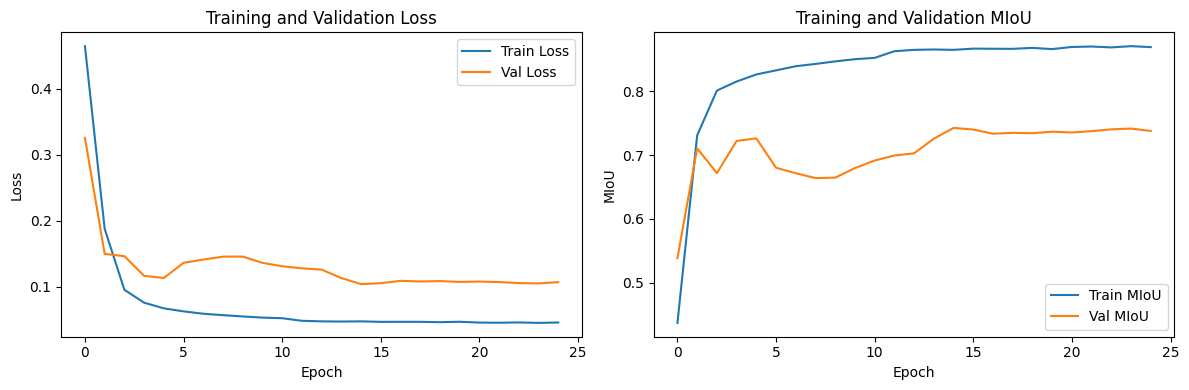

In [18]:
if 'train_losses' in globals() and 'val_losses' in globals() and 'train_mious' in globals() and 'val_mious' in globals():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_mious, label='Train MIoU')
    plt.plot(val_mious, label='Val MIoU')
    plt.xlabel('Epoch')
    plt.ylabel('MIoU')
    plt.legend()
    plt.title('Training and Validation MIoU')
    plt.tight_layout()
    plt.show()
else:
    print("Error: Training metrics not found. Please run the training function first.")

<ipython-input-20-07908ba8b9f7>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


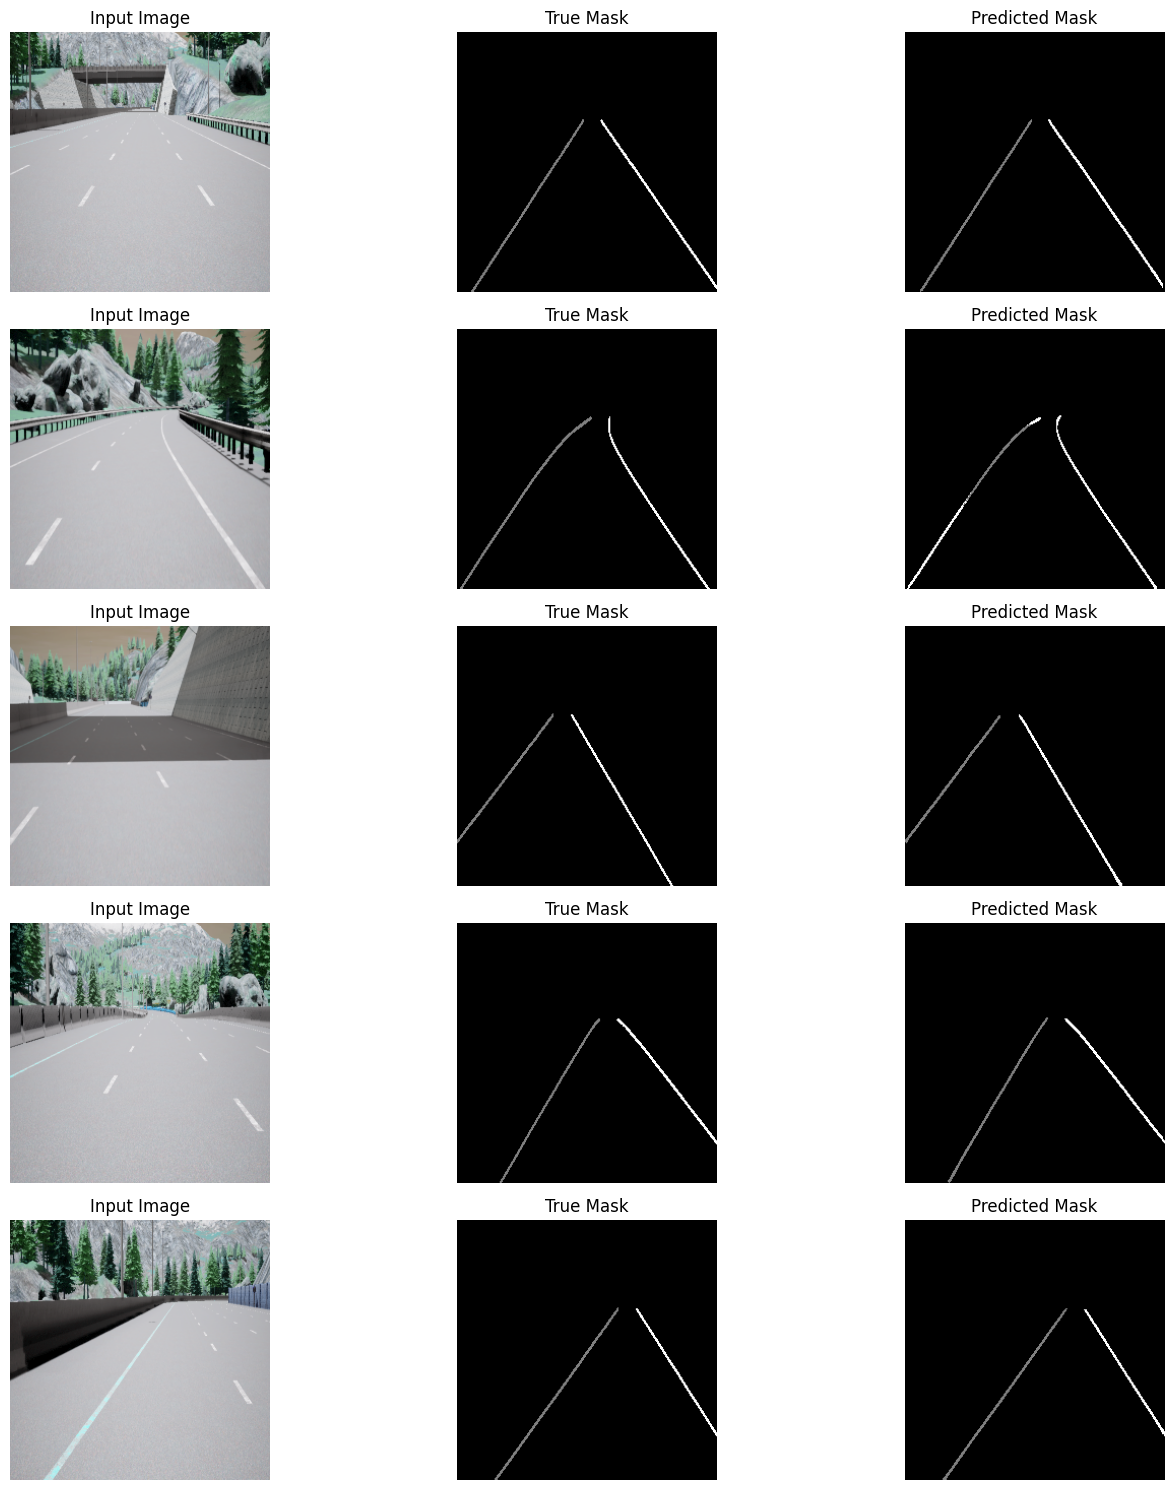

In [20]:
import random

def visualize_random_predictions(model, dataset, device, num_images=5):
    model.eval()
    # Select random indices from the dataset
    indices = random.sample(range(len(dataset)), num_images)
    
    # Create figure for plotting
    fig, ax = plt.subplots(num_images, 3, figsize=(15, num_images * 3))
    
    # Denormalization parameters (ImageNet stats)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            # Get image and mask from dataset
            image, mask = dataset[idx]
            image = image.to(device).unsqueeze(0)  # Add batch dimension
            mask = mask.numpy()  # Convert to numpy for plotting
            
            # Predict with mixed precision
            with autocast():
                output = model(image)
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
            
            # Denormalize image for visualization
            image_np = image.squeeze().cpu().permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
            image_np = (image_np * std + mean) * 255.0  # Denormalize
            image_np = image_np.astype(np.uint8)
            
            # Plot image, true mask, and predicted mask
            ax[i, 0].imshow(image_np)
            ax[i, 0].set_title('Input Image')
            ax[i, 0].axis('off')
            
            ax[i, 1].imshow(mask, cmap='gray')
            ax[i, 1].set_title('True Mask')
            ax[i, 1].axis('off')
            
            ax[i, 2].imshow(pred, cmap='gray')
            ax[i, 2].set_title('Predicted Mask')
            ax[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run visualization on validation dataset
visualize_random_predictions(model, val_dataset, device, num_images=5)

***Saving the model***

In [22]:
model.load_state_dict(torch.load('best_model.pth'))

<ipython-input-22-97ca0473330f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [27]:
torch.save(model.state_dict(), '/kaggle/working/final_lane_segmentation_model.pth')
print("Training complete! Final model saved.")

Training complete! Final model saved.


In [28]:
# STEP 15: Measure Inference Speed
def measure_inference_speed(model, dataloader, device, num_images=10):
    model.eval()
    total_time = 0.0
    images_processed = 0
    
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            
            with autocast():
                start_time = time.time()
                outputs = model(images)
                end_time = time.time()
            
            inference_time = end_time - start_time
            total_time += inference_time
            images_processed += len(images)
            
            if images_processed >= num_images:
                break
    
    avg_inference_time = total_time / images_processed
    fps = 1 / avg_inference_time
    print(f'Average inference time per image: {avg_inference_time:.4f} seconds')
    print(f'Estimated FPS: {fps:.2f}')
    return avg_inference_time

avg_inference_time = measure_inference_speed(model, val_loader, device, num_images=10)

<ipython-input-28-f3fc55a6c0ff>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Average inference time per image: 0.0127 seconds
Estimated FPS: 78.99
